# Initial setup

In [2]:
import os
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import us
from matplotlib.colors import LinearSegmentedColormap
from addfips import AddFIPS

plt.style.use("dark_background")


def read_folder_csv(folder_path):
    # creating dataframe dictionary
    file_list = os.listdir(folder_path)
    dataframes = {}
    for file_name in file_list:
        if file_name.endswith(".csv"):
            key_name = os.path.splitext(file_name)[0]
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            dataframes[key_name] = df
    return dataframes

In [4]:
dataframes = read_folder_csv("election")
pr = dataframes["primary_results"]
cfd = dataframes["county_facts_dictionary"]
cf = dataframes["county_facts"]
# Replace the column name with the description in the original DataFrame
for column_name in cf.columns:
    if column_name in cfd["column_name"].values:
        description = cfd.loc[cfd["column_name"] == column_name, "description"].iloc[0]
        cf.rename(columns={column_name: description}, inplace=True)
cf["area_name"] = cf["area_name"].str.replace("County", "").str.strip()
pr["county"] = pr["county"].str.replace("County", "").str.strip()

# Introduction

We will analyse how people voted based on their geography, income and demography.

Please note, that these are primary election result from March. Actual election was done in November and even though populartiy vote was for Hillary aprox 48.2 % against Trump's 46.1%, Trump won the 2016 presidential election by securing a majority of electoral vote.

Electoral College System: The President of the United States is not elected by the popular vote but by the Electoral College. Each state is allocated a certain number of electoral votes based on its representation in Congress (senators + representatives). In most states, the candidate who wins the popular vote in that state receives all of its electoral votes. The candidate who reaches an absolute majority of 270 out of 538 electoral votes becomes the President.


We will use primary results as reference to candidate popularity. In a primary election, winners are determined within each political party separately. Primary elections are typically held to select the preferred candidate for each political party who will then represent the party in the general election.

The winners of a primary election are determined within each political party. The winning candidate from each party will then compete against candidates from other parties in the general election. The general election determines the ultimate winner who will hold the elected office, such as the presidency or a seat in the legislature.

In [5]:
sv = pd.pivot_table(pr, values="votes", index="state", columns="party", aggfunc="sum")
print("Total Democrat votes:", sv["Democrat"].sum())
print("Total Republican votes:", sv["Republican"].sum())

Total Democrat votes: 27660501.0
Total Republican votes: 29098686.0


# Analysing datasets to define how to merge

In [28]:
for df in dataframes:
    print(dataframes[df].isnull().any().any())

True
False
True


In [29]:
af = AddFIPS()

# Add FIPS codes to the DataFrame
for index, row in pr.iterrows():
    state_name = row["state"]
    county_name = row["county"]
    fips_code = af.get_county_fips(county_name, state=state_name)
    pr.loc[index, "fipsadd"] = fips_code
pr["fipsadd"] = pr["fipsadd"].astype(float)

In [30]:
pr["fips"] = pr["fips"].fillna(pr["fipsadd"])

In [31]:
prf = pd.pivot_table(
    pr,
    index=["fips", "state", "state_abbreviation", "county"],
    columns="candidate",
    values="votes",
    fill_value=0,
)
prf = prf.reset_index()
prf = prf.drop([" No Preference", " Uncommitted"], axis=1)

picking candidates with higher number of votes

In [32]:
prf.iloc[:, 4:].describe()

candidate   Ben Carson  Bernie Sanders  Carly Fiorina  Chris Christie   
count      4217.000000     4217.000000    4217.000000     4217.000000  \
mean        133.875504     2835.926488       3.602324        5.774959   
std         530.134610    12246.270595      78.551516      150.920573   
min           0.000000        0.000000       0.000000        0.000000   
25%           0.000000       98.000000       0.000000        0.000000   
50%           0.000000      448.000000       0.000000        0.000000   
75%          49.000000     1544.000000       0.000000        0.000000   
max        9945.000000   434656.000000    3612.000000     7144.000000   

candidate   Donald Trump  Hillary Clinton     Jeb Bush    John Kasich   
count        4217.000000      4217.000000  4217.000000    4217.000000  \
mean         3154.503438      3721.235950    22.388191     986.471188   
std          8403.605681     16889.242651   297.752447    3984.254975   
min             0.000000         0.000000     0.000000       0.000000   
25%           123.000000        56.000000     0.000000      22.000000   
50%           795.000000       544.000000     0.000000     123.000000   
75%          2538.000000      1741.000000     0.000000     485.000000   
max        179130.000000    590502.000000  9575.000000  101217.000000   

candidate    Marco Rubio  Martin O'Malley  Mike Huckabee    Rand Paul   
count        4217.000000      4217.000000    4217.000000  4217.000000  \
mean          787.544700         0.178326       0.793218     2.010671   
std          3536.914936         3.140144      10.347424    33.614465   
min             0.000000         0.000000       0.000000     0.000000   
25%             0.000000         0.000000       0.000000     0.000000   
50%            59.000000         0.000000       0.000000     0.000000   
75%           369.000000         0.000000       0.000000     0.000000   
max        111898.000000       152.000000     565.000000  1633.000000   

candidate  Rick Santorum       Ted Cruz  
count        4217.000000    4217.000000  
mean            0.422575    1802.941902  
std             5.635955    5229.629532  
min             0.000000       0.000000  
25%             0.000000      45.000000  
50%             0.000000     339.000000  
75%             0.000000    1437.000000  
max           234.000000  147721.000000

In [33]:
prf = prf.drop(
    [
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "Marco Rubio",
    ],
    axis=1,
)

In [34]:
af = AddFIPS()

# Add FIPS codes to the DataFrame
for index, row in prf.iterrows():
    state_name = row["state"]
    county_name = row["county"]
    fips_code = af.get_county_fips(county_name, state=state_name)
    prf.loc[index, "fipsadd"] = fips_code
prf["fipsadd"] = prf["fipsadd"].astype(float)

comparing fipsadd and fips columns

In [35]:
u = prf["fipsadd"].isin(prf["fips"])
prf9 = prf[~u][prf[~u]["fips"] > 10000000]
print("fipsadd is not null - for fips above 90 m")
print(prf9[~prf9["fipsadd"].isnull()].shape[0])
print("fipsadd is null - for fips above 90 m")
print(prf9[prf9["fipsadd"].isnull()].shape[0])
prfn9 = prf[~u][prf[~u]["fips"] < 10000000]
print("fipsadd is not null - for fips bellow 90 m")
print(prfn9[~prfn9["fipsadd"].isnull()].shape[0])
print("fipsadd is null - for fips bellow 90 m")
print(prfn9[prfn9["fipsadd"].isnull()].shape[0])

fipsadd is not null - for fips above 90 m
39
fipsadd is null - for fips above 90 m
1369
fipsadd is not null - for fips bellow 90 m
2
fipsadd is null - for fips bellow 90 m
10


In [36]:
prf = prf.drop("fipsadd", axis=1)

In [37]:
u = prf["fips"].isin(cf["fips"])
print("fips that are in prf but not in cf")
prnf = prf[~u]
prnf["fips"].nunique()

fips that are in prf but not in cf


1409

In [38]:
prnf.head(2)

candidate        fips   state state_abbreviation                  county   
2808       90200101.0  Alaska                 AK  State House District 1  \
2809       90200102.0  Alaska                 AK  State House District 2   

candidate  Bernie Sanders  Donald Trump  Hillary Clinton  John Kasich   
2808                    9           134                3           12  \
2809                    5            90                1            7   

candidate  Ted Cruz  
2808            151  
2809            103

In [39]:
prnf[prnf["Bernie Sanders"] > 100000]

candidate        fips     state state_abbreviation        county   
3017       91700103.0  Illinois                 IL       Chicago  \
3018       91700104.0  Illinois                 IL  Cook Suburbs   

candidate  Bernie Sanders  Donald Trump  Hillary Clinton  John Kasich   
3017               311225         32858           366954        21654  \
3018               212428         91520           249217        53481   

candidate  Ted Cruz  
3017          17737  
3018          50667

In [40]:
u4 = cf["fips"].isin(prf[prf["fips"] < 1000000]["fips"])
print(cf[~u4]["fips"].nunique())
u5 = prf[prf["fips"] > 10000000]["fips"].isin(cf["fips"])
print(prf[prf["fips"] > 10000000][~u5]["fips"].nunique())

387
1409


there are counties 1409 in primary that are not in county facts

Comparing states, all states that are primary results are in county facts

In [41]:
prf[~prf["state_abbreviation"].isin(cf["state_abbreviation"])]

Empty DataFrame
Columns: [fips, state, state_abbreviation, county, Bernie Sanders, Donald Trump, Hillary Clinton, John Kasich, Ted Cruz]
Index: []

primary results are missing DC and MN, however county facts cover all states, that are in primary results, so we can merge two datasets 

# 2016 primary election analysis on on state level 
(with primary ellection and county facts dataset)

In [43]:
sf = cf[cf["state_abbreviation"].isna()].drop(0)
sf = (
    sf.drop("state_abbreviation", axis=1)
    .rename(columns={"area_name": "state"})
    .set_index("state")
)

In [44]:
# Create a dictionary of DataFrames
states = {
    "psf": sf.iloc[:, 1:4],
    "asf": sf.iloc[:, 5:8],
    "ssf": sf.iloc[:, 8],
    "rsf": sf.iloc[:, 9:17],
    "livingInSameHouse": sf.iloc[:, 17],
    "foreignburn": sf.iloc[:, 18],
    "otherlanguageathome": sf.iloc[:, 19],
    "degreesf": sf.iloc[:, 20:23],
    "traveltowork": sf.iloc[:, 23],
    "hsf": sf.iloc[:, 24:30],
    "isf": sf.iloc[:, 30:33],
    "fsf": sf.iloc[:, 34:49],
    "lsf": sf.iloc[:, 50:52],
}

Creating public results per state

In [45]:
gs = pr.groupby(by=["state", "candidate"]).agg({"votes": "sum"})
prs = pd.pivot_table(
    gs, index="state", columns="candidate", values="votes", fill_value=0
)
prs = prs.drop(
    [
        " No Preference",
        " Uncommitted",
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "Marco Rubio",
    ],
    axis=1,
)

In [46]:
gs = pr.groupby(by=["state", "candidate"]).agg({"fraction_votes": "sum"})
prsf = pd.pivot_table(
    gs, index="state", columns="candidate", values="fraction_votes", fill_value=0
)
prsf = prsf.drop(
    [
        " No Preference",
        " Uncommitted",
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "Marco Rubio",
    ],
    axis=1,
)

In [47]:
prstates = {}
for dataframe, df in states.items():
    updated_df = prs.merge(df, left_index=True, right_on="state")
    prstates[dataframe] = updated_df

In [48]:
for dfn in prstates:
    dfn = prstates[dfn]

# Population data

In [106]:
psf = prstates["psf"]
psf.head(3)

Bernie Sanders  Donald Trump  Hillary Clinton  John Kasich  Ted Cruz   
state                                                                           
Alabama           76399        371735           309928        37970    180608  \
Alaska              440          7346               99          892      7973   
Arizona          163400        249916           235697        53040    132147   

         Population, 2014 estimate  Population, 2010 (April 1) estimates base   
state                                                                           
Alabama                    4849377                                    4780127  \
Alaska                      736732                                     710249   
Arizona                    6731484                                    6392310   

         Population, percent change - April 1, 2010 to July 1, 2014  
state                                                                
Alabama                                                1.4           
Alaska                                                 3.7           
Arizona                                                5.3

In [50]:
def get_state_name(state_code):
    try:
        state = us.states.lookup(state_code)
        if state is not None:
            return state.name
        else:
            return "Unknown"
    except Exception as e:
        print(f"Error occurred while looking up state name: {e}")
        return "Error"


# Read the shapefile containing county boundaries
shapefile_path = "election/county_shapefiles/cb_2014_us_county_5m.shp"
counties_df = gpd.read_file(shapefile_path)
# Aggregate counties to obtain state boundaries
states_df = counties_df.dissolve(by="STATEFP", aggfunc="first")
# Calculate centroids of each state
states_df["centroid"] = states_df["geometry"].apply(lambda geom: geom.centroid)
states_df["state"] = states_df.index.map(get_state_name)

In [84]:
def plot_map(dataframe, column_name):
    cmap = plt.cm.Reds
    norm = plt.Normalize(vmin=0, vmax=2000000)
    dataframe.plot(
        ax=ax,
        column=column_name,
        cmap=cmap,
        linewidth=0.8,
        edgecolor="black",
        norm=norm,
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)


def plot_pr_map(df, column):
    # prepare datafarme and run ploting function
    states = states_df.join(df[column], on="state")
    plot_map(states, column)

In [65]:
psf.head()

Bernie Sanders  Donald Trump  Hillary Clinton  John Kasich   
state                                                                    
Alabama              76399        371735           309928        37970  \
Alaska                 440          7346               99          892   
Arizona             163400        249916           235697        53040   
Arkansas             64868        133144           144580        15098   
California         1502043       1174829          1940580       176620   

            Ted Cruz  Population, 2014 estimate   
state                                             
Alabama       180608                    4849377  \
Alaska          7973                     736732   
Arizona       132147                    6731484   
Arkansas      123873                    2966369   
California    144125                   38802500   

            Population, 2010 (April 1) estimates base   
state                                                   
Alabama                                       4780127  \
Alaska                                         710249   
Arizona                                       6392310   
Arkansas                                      2915958   
California                                   37254503   

            Population, percent change - April 1, 2010 to July 1, 2014  
state                                                                   
Alabama                                                   1.4           
Alaska                                                    3.7           
Arizona                                                   5.3           
Arkansas                                                  1.7           
California                                                4.2

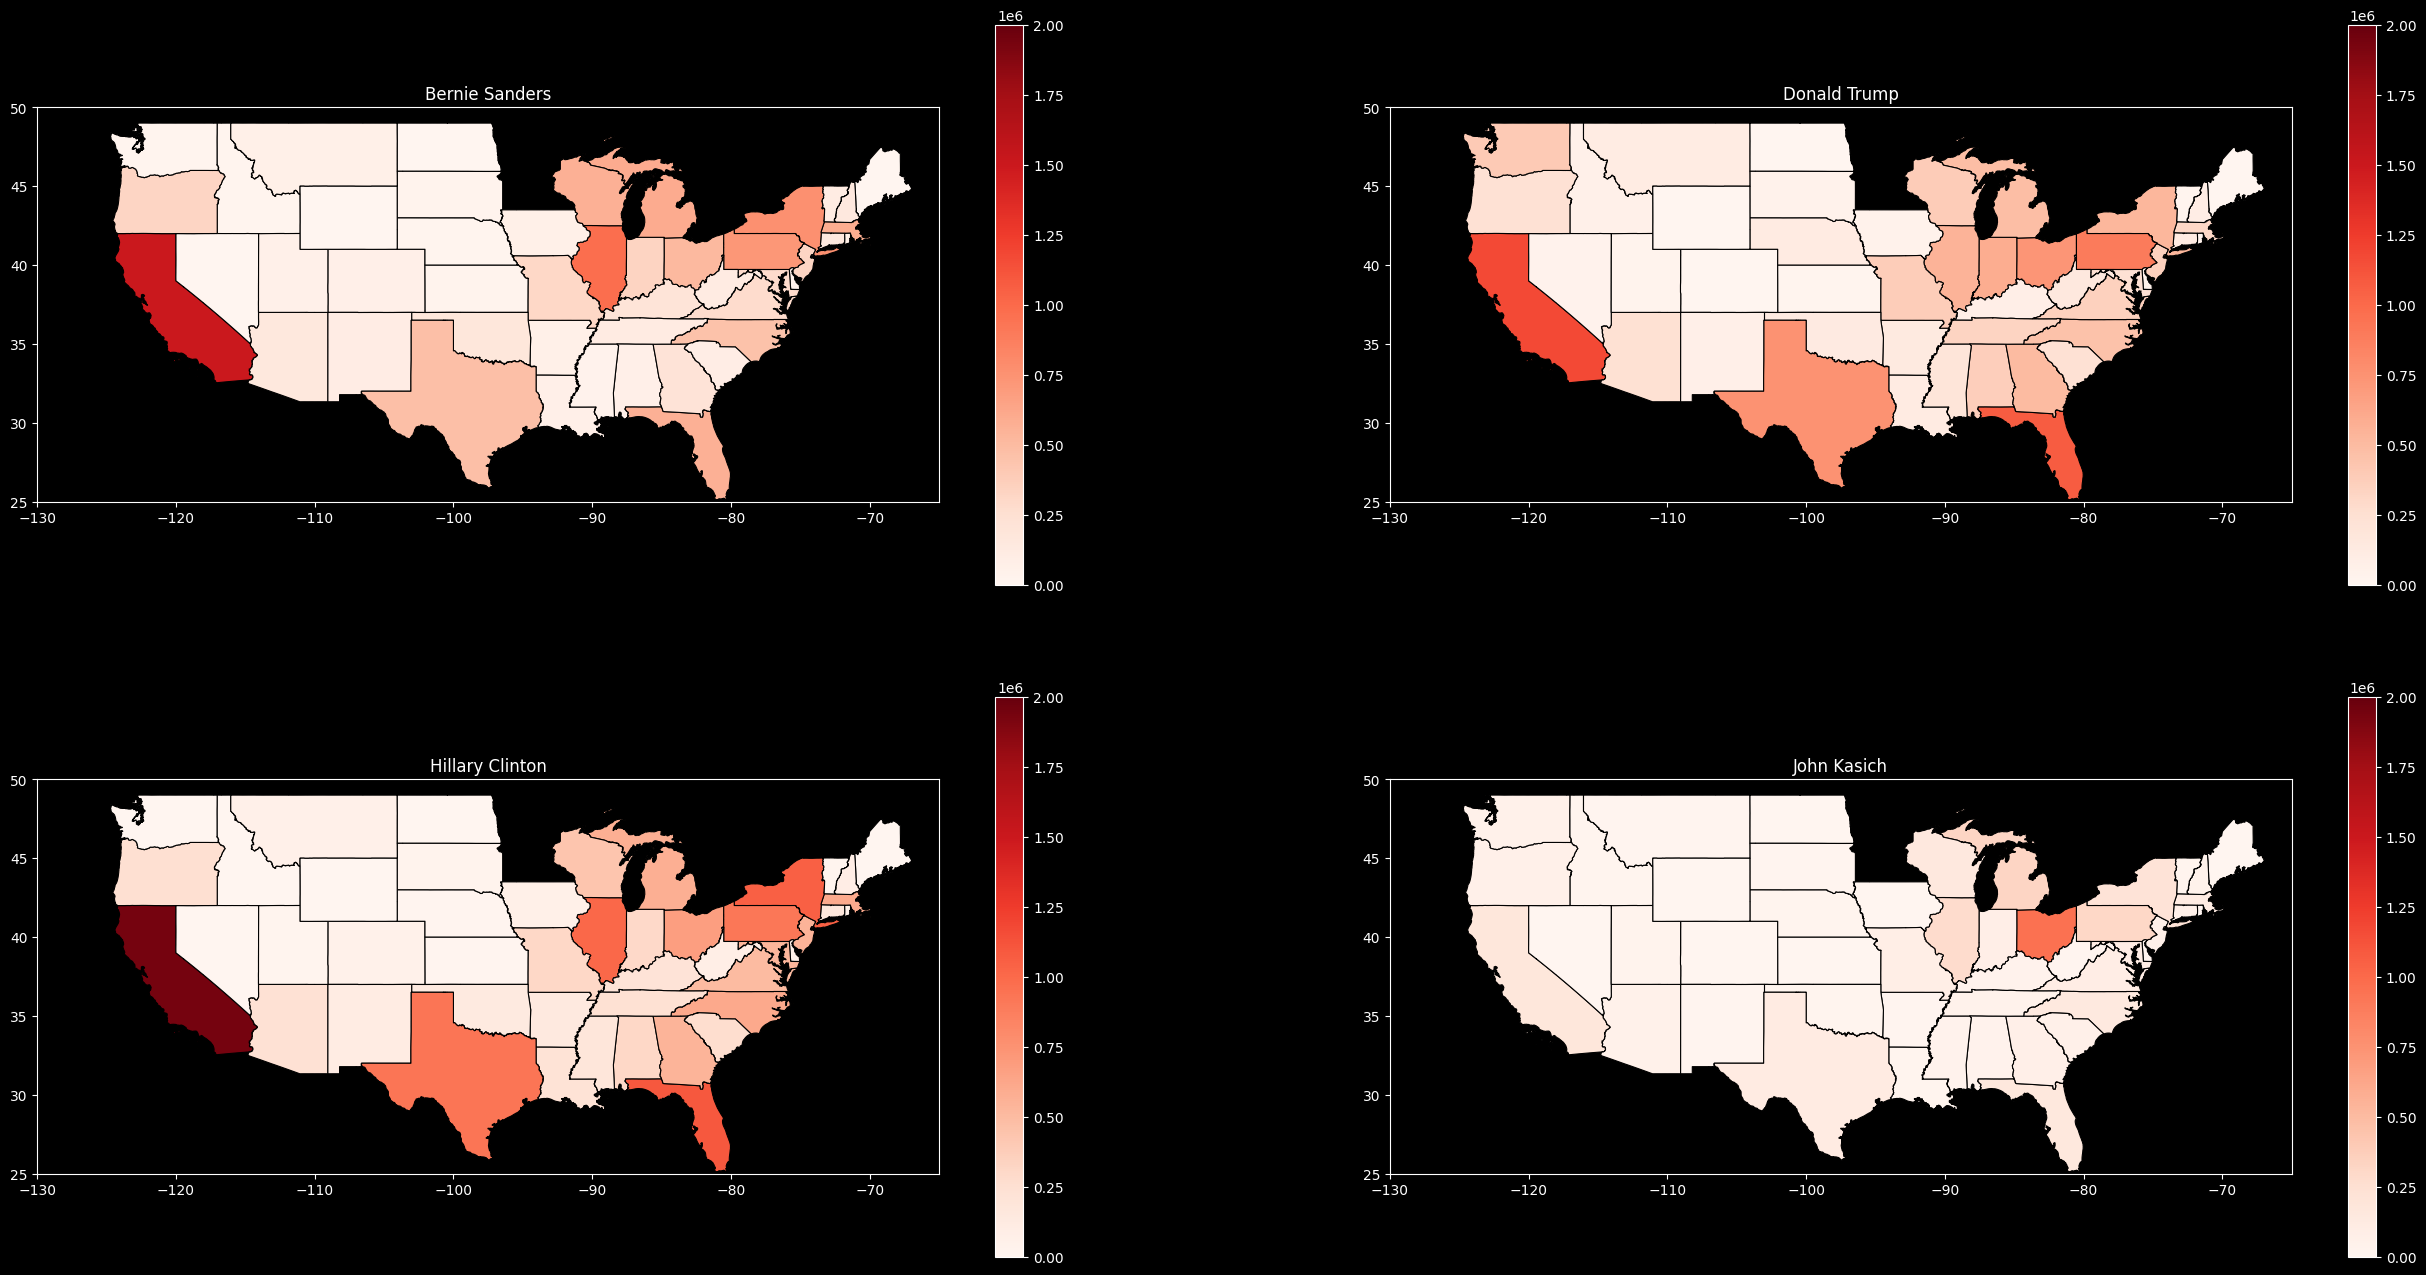

In [85]:
selected_columns = psf.iloc[:, :4]
num_plots = selected_columns.shape[1]
num_rows = num_plots // 2
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(32, 16))
for i, ax in enumerate(axs.flat):
    if i < num_plots:
        column_data = selected_columns.columns[i]
        plot_pr_map(psf, column=column_data)
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
        ax.set_title(column_data)

In [92]:
psf.describe()

Bernie Sanders  Donald Trump  Hillary Clinton    John Kasich   
count    4.900000e+01  4.900000e+01     4.900000e+01      49.000000  \
mean     2.440633e+05  2.714804e+05     3.202541e+05   84896.918367   
std      2.994654e+05  2.863348e+05     3.938380e+05  150317.144635   
min      1.560000e+02  0.000000e+00     9.900000e+01       0.000000   
25%      3.665900e+04  4.486600e+04     2.704600e+04   13685.000000   
50%      1.203330e+05  1.562450e+05     1.824470e+05   37970.000000   
75%      3.232590e+05  3.863700e+05     5.332470e+05   96519.000000   
max      1.502043e+06  1.174829e+06     1.940580e+06  956762.000000   

           Ted Cruz  Population, 2014 estimate   
count  4.900000e+01               4.900000e+01  \
mean   1.551634e+05               6.382469e+06   
std    2.131757e+05               7.223838e+06   
min    0.000000e+00               5.841530e+05   
25%    1.607900e+04               1.850326e+06   
50%    8.203800e+04               4.413457e+06   
75%    1.806080e+05               7.061530e+06   
max    1.239370e+06               3.880250e+07   

       Population, 2010 (April 1) estimates base   
count                               4.900000e+01  \
mean                                6.180661e+06   
std                                 6.918300e+06   
min                                 5.637670e+05   
25%                                 1.826341e+06   
50%                                 4.339349e+06   
75%                                 6.724543e+06   
max                                 3.725450e+07   

       Population, percent change - April 1, 2010 to July 1, 2014  
count                                          49.000000           
mean                                            2.969388           
std                                             2.174109           
min                                            -0.100000           
25%                                             1.200000           
50%                                             3.000000           
75%                                             4.300000           
max                                             9.900000

# County level

## Create county data frames

In [8]:
pivot_table = pr.pivot_table(
    index=["fips", "state_abbreviation", "county"],
    columns="candidate",
    values="votes",
    aggfunc="sum",
    fill_value=0,
)
pivot_table = pivot_table.reset_index()
ccf = cf.rename(columns={"area_name": "county"})
df = pivot_table.merge(ccf, on="fips", how="outer").drop(
    [" No Preference", " Uncommitted"], axis=1
)
df = df.drop(
    [
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "county_y",
        "state_abbreviation_y",
    ],
    axis=1,
)

gdf = df.dropna()
gdf = gdf.set_index("fips")
vfdf = gdf.iloc[:, 0:8]
pfdf = gdf.iloc[:, 9:13]
ifdf = gdf.iloc[:, 37:40]
afdf = gdf.iloc[:, 14:17]
rfdf = gdf.iloc[:, 16:23]


def cdf(df2):
    # creating dataframe with votes and one of county facts categories
    return vfdf.merge(df2, left_index=True, right_index=True)

## Correlation (positive/negative)

In [57]:
c = gdf.iloc[:, 2:].corr().iloc[6:, :3]
print(c.iloc[:, [0, 1]][(c.iloc[:, 0] - c.iloc[:, 1]).abs() > 0.1])
print(c.iloc[:, [0, 2]][(c.iloc[:, 2] - c.iloc[:, 0]).abs() > 0.08])
c.iloc[:, [2, 1]][(c.iloc[:, 1] - c.iloc[:, 2]).abs() > 0.11]

                                  Bernie Sanders  Donald Trump
Veterans, 2009-2013                     0.793003      0.901457
Population per square mile, 2010        0.364450      0.158780
                                                Bernie Sanders   
Black or African American alone, percent, 2014        0.058248  \
Black-owned firms, percent, 2007                      0.152268   

                                                Hillary Clinton  
Black or African American alone, percent, 2014         0.139878  
Black-owned firms, percent, 2007                       0.241371  


Hillary Clinton   
White alone, percent, 2014                                -0.201367  \
Black or African American alone, percent, 2014             0.139878   
White alone, not Hispanic or Latino, percent, 2014        -0.252965   
Homeownership rate, 2009-2013                             -0.307699   
Persons below poverty level, percent, 2009-2013           -0.049520   
Private nonfarm employment,  2013                          0.904976   
Nonemployer establishments, 2013                           0.915226   
Total number of firms, 2007                                0.919458   
Merchant wholesaler sales, 2007 ($1,000)                   0.784110   
Population per square mile, 2010                           0.433144   

                                                    Donald Trump  
White alone, percent, 2014                             -0.084186  
Black or African American alone, percent, 2014          0.029812  
White alone, not Hispanic or Latino, percent, 2014     -0.133238  
Homeownership rate, 2009-2013                          -0.186892  
Persons below poverty level, percent, 2009-2013        -0.166732  
Private nonfarm employment,  2013                       0.794732  
Nonemployer establishments, 2013                        0.775525  
Total number of firms, 2007                             0.796056  
Merchant wholesaler sales, 2007 ($1,000)                0.664344  
Population per square mile, 2010                        0.158780

## population

In [102]:
df = cdf(pfdf)

In [59]:
candidates = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
    "John Kasich",
    "Marco Rubio",
    "Ted Cruz",
]
shapefile_path = "election/county_shapefiles/cb_2014_us_county_5m.shp"
data = gpd.read_file(shapefile_path)
mdf = counties_df.merge(df, left_on="NAME", right_on="county_x")

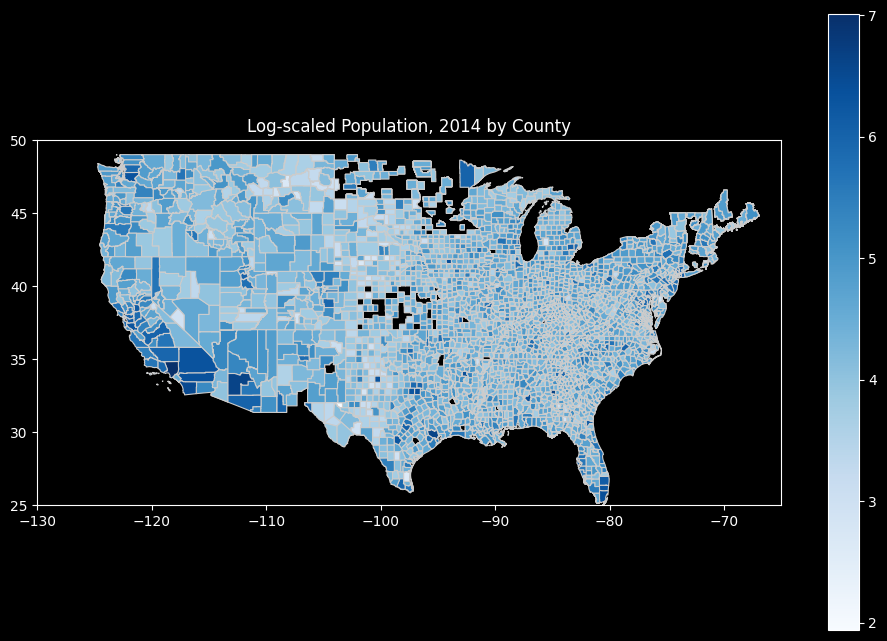

In [60]:
# Calculate the Population, 2014 column
df["Population, 2010 (April 1) estimates base"] = pd.to_numeric(
    df["Population, 2010 (April 1) estimates base"], errors="coerce"
)
df["Population, percent change - April 1, 2010 to July 1, 2014"] = pd.to_numeric(
    df["Population, percent change - April 1, 2010 to July 1, 2014"], errors="coerce"
)
df["Population, 2014"] = df["Population, 2010 (April 1) estimates base"] * (
    1 + df["Population, percent change - April 1, 2010 to July 1, 2014"] / 100
)

mdf = counties_df.merge(df, left_on="NAME", right_on="county_x")
mdf["Population, 2014 (log)"] = np.log10(mdf["Population, 2014"])

fig, ax = plt.subplots(figsize=(12, 8))
mdf.plot(
    column="Population, 2014 (log)",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
)

ax.set_title("Log-scaled Population, 2014 by County")
ax.set_xlim(-130, -65)
ax.set_ylim(25, 50)

plt.show()

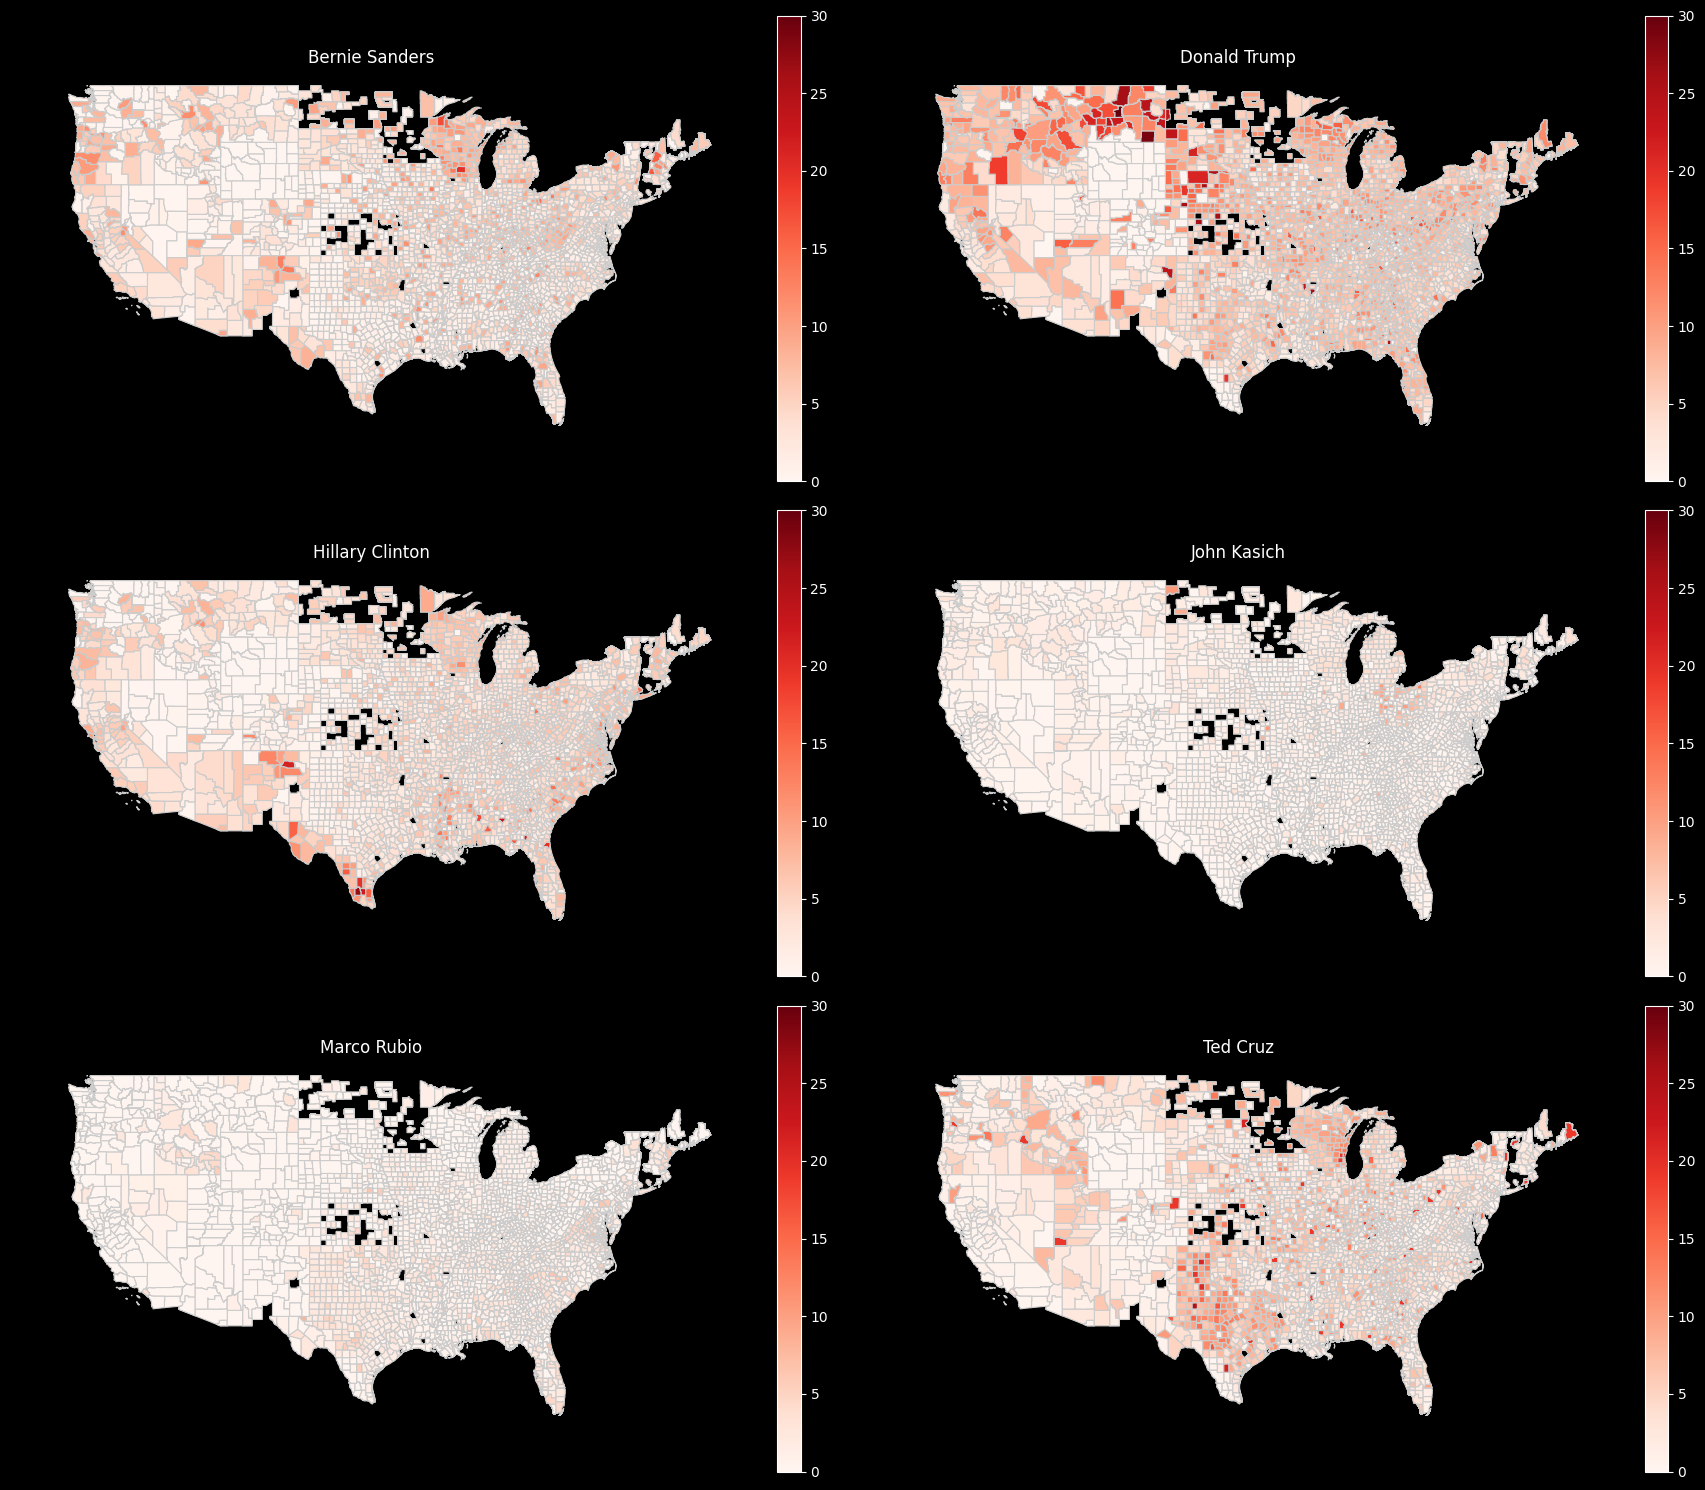

In [95]:
fig, axs = plt.subplots(
    len(candidates) // 2, 2, figsize=(18, 5 * (len(candidates) // 2))
)

cmap = plt.cm.Reds
norm = plt.Normalize(vmin=0, vmax=30)
# Plot maps for each candidate
for i, candidate in enumerate(candidates):
    ax = axs[i // 2, i % 2]
    mdf[candidate + "_percent"] = (mdf[candidate] / mdf["Population, 2014"]) * 100
    mdf.plot(
        ax=ax,
        column=candidate + "_percent",
        cmap=cmap,
        linewidth=0.8,
        edgecolor="0.8",
        legend=True,
        norm=norm,
    )
    ax.set_title(candidate)
    ax.set_axis_off()
    ax.set_xlim(-130, -65)
    ax.set_ylim(25, 50)

plt.tight_layout()
plt.show()

put more info here

trump dominated more in republicans then clinton in democrats

In [97]:
mdf.iloc[:,-8:].describe()

Population, 2014  Population, 2014 (log)  Bernie Sanders_percent   
count      1.371500e+04            13715.000000            13715.000000  \
mean       8.933024e+04                4.502186                3.070965   
std        2.334541e+05                0.572020                2.338691   
min        8.601800e+01                1.934589                0.000000   
25%        1.358100e+04                4.132932                1.212280   
50%        2.793285e+04                4.446115                2.568936   
75%        6.239419e+04                4.795144                4.335320   
max        1.011322e+07                7.004890               19.866055   

       Donald Trump_percent  Hillary Clinton_percent  John Kasich_percent   
count          13715.000000             13715.000000         13715.000000  \
mean               6.404378                 3.969347             1.311385   
std                3.789864                 3.038722             1.746760   
min                0.000000                 0.000000             0.000000   
25%                3.738686                 2.191607             0.380165   
50%                6.306519                 3.450805             0.819024   
75%                8.436652                 5.075464             1.514732   
max               34.425324                35.760672            17.383903   

       Marco Rubio_percent  Ted Cruz_percent  
count         13715.000000      13715.000000  
mean              1.165928          3.917975  
std               1.298492          2.805138  
min               0.000000          0.000000  
25%               0.000000          1.822006  
50%               0.827702          3.254109  
75%               1.786437          5.572656  
max               9.980810         25.157348

In [413]:
mdf.iloc[:, -2:].describe()

Population, 2014  Population, 2014 (log)
count      1.371500e+04            13715.000000
mean       8.933024e+04                4.502186
std        2.334541e+05                0.572020
min        8.601800e+01                1.934589
25%        1.358100e+04                4.132932
50%        2.793285e+04                4.446115
75%        6.239419e+04                4.795144
max        1.011322e+07                7.004890

### votes that are not in merged df

In [234]:
# df[df['county_y'].isnull()]['state_abbreviation_x'].unique()

array(['AK', 'CT', 'IL', 'KS', 'ME', 'MA', 'ND', 'RI', 'VT', 'WY'],
      dtype=object)

In [342]:
gv = df.iloc[:, 3:9]
gv.sum()

Bernie Sanders     11807518.0
Donald Trump       13202135.0
Hillary Clinton    15597200.0
John Kasich         4115040.0
Marco Rubio         3291044.0
Ted Cruz            7569817.0
dtype: float64

In [355]:
mv = df[df["county_y"].isnull()].iloc[:, 3:9]
mv.sum()

Bernie Sanders     1474706.0
Donald Trump        642563.0
Hillary Clinton    1474865.0
John Kasich         291558.0
Marco Rubio         171762.0
Ted Cruz            209992.0
dtype: float64

currently miaaing % of votes in county facts

In [354]:
mv.sum(axis=1).sum() / gv.sum(axis=1).sum() * 100

7.6740458020485995

In [356]:
mv.sum() / gv.sum() * 100

Bernie Sanders     12.489551
Donald Trump        4.867114
Hillary Clinton     9.455960
John Kasich         7.085180
Marco Rubio         5.219073
Ted Cruz            2.774070
dtype: float64

In [360]:
df[df["county_y"].isnull()][["fips", "state_abbreviation_x", "county_x"]]

fips state_abbreviation_x                county_x
2798  90200101.0                   AK  State House District 1
2799  90200102.0                   AK  State House District 2
2800  90200103.0                   AK  State House District 3
2801  90200104.0                   AK  State House District 4
2802  90200105.0                   AK  State House District 5
...          ...                  ...                     ...
4202  95600032.0                   WY        Campbell-Johnson
4203  95600033.0                   WY            Crook-Weston
4204  95600034.0                   WY       Converse-Niobrara
4205  95600035.0                   WY           Goshen-Platte
4206  95600036.0                   WY                 Laramie

[1409 rows x 3 columns]

In [361]:
df[df["county_x"].isnull()][["fips", "state_abbreviation_y", "county_y"]]

fips state_abbreviation_y                    county_y
4207      0.0                  NaN               United States
4208   1000.0                  NaN                     Alabama
4209   2000.0                  NaN                      Alaska
4210   2013.0                   AK      Aleutians East Borough
4211   2016.0                   AK  Aleutians West Census Area
...       ...                  ...                         ...
4599  51515.0                   VA                Bedford city
4600  53000.0                  NaN                  Washington
4601  54000.0                  NaN               West Virginia
4602  55000.0                  NaN                   Wisconsin
4603  56000.0                  NaN                     Wyoming

[397 rows x 3 columns]

### checking merged df without nan counties

In [366]:
gdf[gdf["county_x"] != gdf["county_y"]]

fips state_abbreviation_x        county_x  Bernie Sanders   
143    5123.0                   AR   Saint Francis           354.0  \
574   17039.0                   IL          DeWitt           659.0   
597   17085.0                   IL       JoDaviess          1225.0   
909   21123.0                   KY           LaRue           910.0   
968   22001.0                   LA          Acadia          1087.0   
...       ...                  ...             ...             ...   
2604  51800.0                   VA         Suffolk          1893.0   
2605  51810.0                   VA  Virginia Beach         12969.0   
2606  51820.0                   VA      Waynesboro           769.0   
2607  51830.0                   VA    Williamsburg          1197.0   
2608  51840.0                   VA      Winchester           900.0   

      Donald Trump  Hillary Clinton  John Kasich  Marco Rubio  Ted Cruz   
143          598.0           1912.0         19.0        236.0     494.0  \
574         1577.0            561.0        402.0        255.0    1489.0   
597         1666.0           1315.0        846.0        391.0    1153.0   
909          264.0            612.0         76.0        110.0     275.0   
968         1694.0           1862.0        129.0        403.0    1454.0   
...            ...              ...          ...          ...       ...   
2604        3732.0           7533.0        641.0       2952.0    1372.0   
2605       22139.0          22352.0       4962.0      18068.0    6720.0   
2606         910.0            788.0        230.0        817.0     580.0   
2607         336.0           1159.0        344.0        630.0     148.0   
2608         871.0            949.0        294.0        843.0     475.0   

                 county_y  ... Hispanic-owned firms, percent, 2007   
143           St. Francis  ...                                 1.4  \
574               De Witt  ...                                 0.0   
597            Jo Daviess  ...                                 0.0   
909                 Larue  ...                                 0.0   
968         Acadia Parish  ...                                 1.4   
...                   ...  ...                                 ...   
2604         Suffolk city  ...                                 0.0   
2605  Virginia Beach city  ...                                 2.4   
2606      Waynesboro city  ...                                 0.0   
2607    Williamsburg city  ...                                 0.0   
2608      Winchester city  ...                                 0.0   

      Women-owned firms, percent, 2007   
143                               38.8  \
574                                0.0   
597                               23.0   
909                                0.0   
968                               25.4   
...                                ...   
2604                              29.6   
2605                              31.6   
2606                              24.8   
2607                              22.7   
2608                              20.7   

      Manufacturers shipments, 2007 ($1,000)   
143                                      0.0  \
574                                      0.0   
597                                 419517.0   
909                                  90029.0   
968                                      0.0   
...                                      ...   
2604                               1307801.0   
2605                               1806461.0   
2606                                759893.0   
2607                                     0.0   
2608                                     0.0   

      Merchant wholesaler sales, 2007 ($1,000)  Retail sales, 2007 ($1,000)   
143                                        0.0                     353772.0  \
574                                   248857.0                     188199.0   
597                                   120531.0                     310735.0   
909                         

## Income

In [68]:
df = cdf(ifdf)

update columns
use heads

In [70]:
bin_edges = range(
    0,
    int(df["Per capita money income in past 12 months (2013 dollars), 2009-2013"].max())
    + 10000,
    10000,
)
candidate_cols = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
    "John Kasich",
    "Marco Rubio",
]
total_votes = df[candidate_cols].sum()
percent_votes = (df[candidate_cols] / total_votes) * 100

pie_data = []
for i in range(len(bin_edges) - 1):
    votes_in_bin = df[
        (df.iloc[:, 8] >= bin_edges[i]) & (df.iloc[:, 8] < bin_edges[i + 1])
    ]
    pie_values = percent_votes.loc[votes_in_bin.index].mean()
    pie_data.append(pie_values)
    vote_count = votes_in_bin[candidate_cols].sum().sum()
    pie_data.append(vote_count)

In [69]:
df.iloc[:,8 ]

fips
1001.0     24571.0
1003.0     26766.0
1005.0     16829.0
1007.0     17427.0
1009.0     20730.0
            ...   
56037.0    30517.0
56039.0    43444.0
56041.0    25513.0
56043.0    28308.0
56045.0    28764.0
Name: Per capita money income in past 12 months (2013 dollars), 2009-2013, Length: 2798, dtype: float64

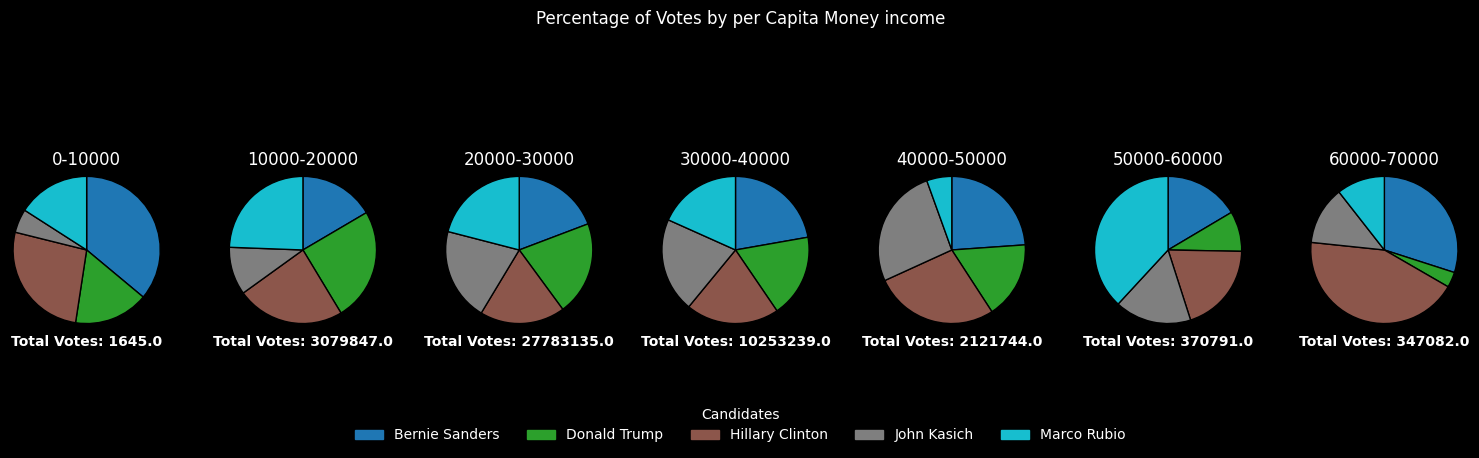

In [71]:
fig, axs = plt.subplots(1, len(pie_data) // 2, figsize=(15, 5))
colors = plt.cm.tab10(np.linspace(0, 1, len(candidate_cols)))
for i, pie_values in enumerate(pie_data[::2]):
    ax = axs[i]
    ax.pie(
        pie_values,
        startangle=90,
        counterclock=False,
        radius=1.2,
        wedgeprops={"edgecolor": "black"},
        colors=colors,
    )
    ax.set_title(f"{i * 10000}-{(i + 1) * 10000}")
    vote_count = pie_data[i * 2 + 1]
    vote_text = f"Total Votes: {vote_count}"
    ax.text(
        0,
        -1.5,
        vote_text,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=10,
        weight="bold",
    )

legend_handles = [
    mpatches.Patch(color=colors[i], label=candidate)
    for i, candidate in enumerate(candidate_cols)
]
fig.legend(
    handles=legend_handles,
    loc="center",
    bbox_to_anchor=(0.5, 0.15),
    bbox_transform=plt.gcf().transFigure,
    ncol=len(candidate_cols),
    frameon=False,
    title="Candidates",
    prop={"size": 10},
)

fig.tight_layout(rect=[0, 0.2, 1, 0.8])
plt.suptitle("Percentage of Votes by per Capita Money income")
plt.show()

using stack bars or histograms or use subplots

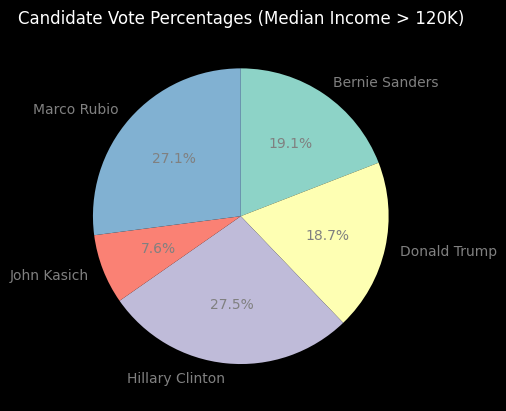

In [72]:
filtered_data = df[df["Median household income, 2009-2013"] > 120000]
vote_percentages = (
    filtered_data[candidate_cols].sum() / filtered_data[candidate_cols].sum().sum()
)
fig, ax = plt.subplots()
ax.pie(
    vote_percentages,
    labels=candidate_cols,
    startangle=90,
    counterclock=False,
    autopct="%1.1f%%",
    textprops={"color": "grey"},
)
ax.set_title("Candidate Vote Percentages (Median Income > 120K)")
plt.show()

no legend

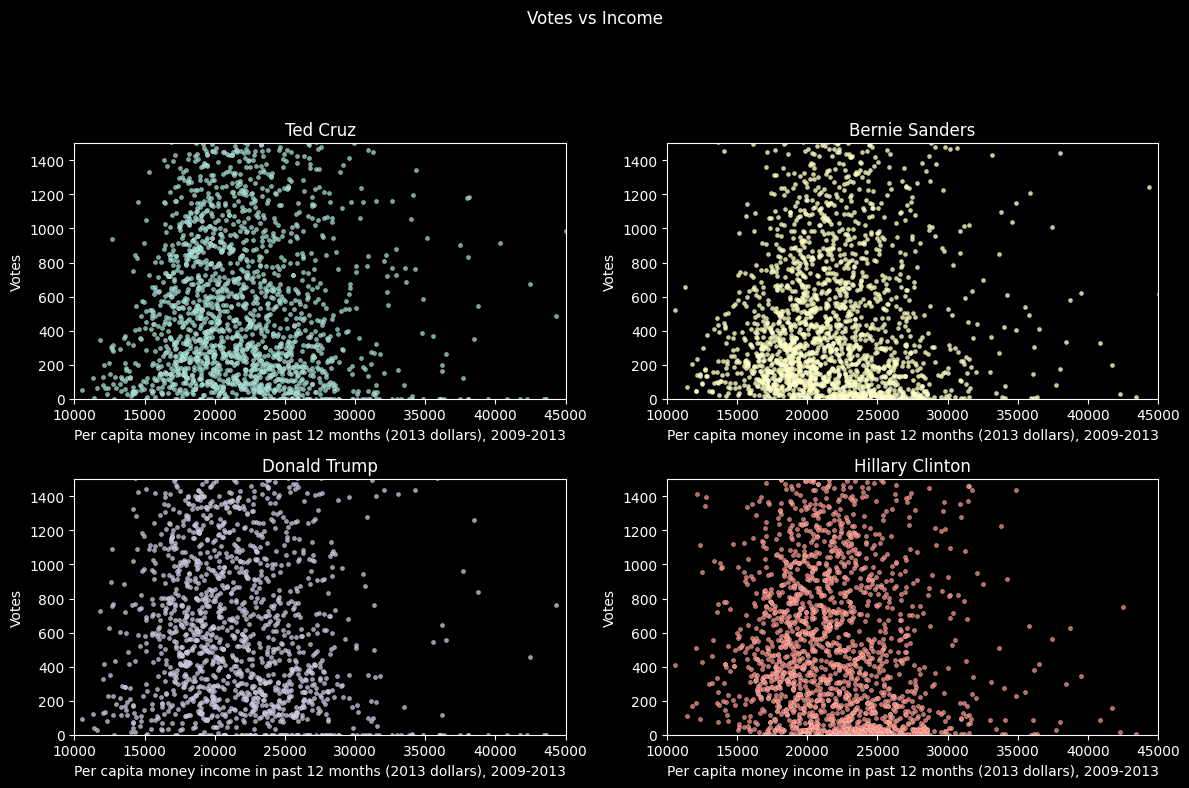

In [80]:
x = df["Per capita money income in past 12 months (2013 dollars), 2009-2013"]
candidate_cols = ["Ted Cruz", "Bernie Sanders", "Donald Trump", "Hillary Clinton"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, candidate in enumerate(candidate_cols):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    y = df[candidate]
    sns.scatterplot(x=x, y=y, color=f"C{i}", alpha=0.8, ax=ax, s = 9)
    ax.set_xlabel("Per capita money income in past 12 months (2013 dollars), 2009-2013")
    ax.set_ylabel("Votes")
    ax.set_title(candidate)
    ax.set_ylim(0, 1500)
    ax.set_xlim(10000, 45000)

plt.suptitle("Votes vs Income")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

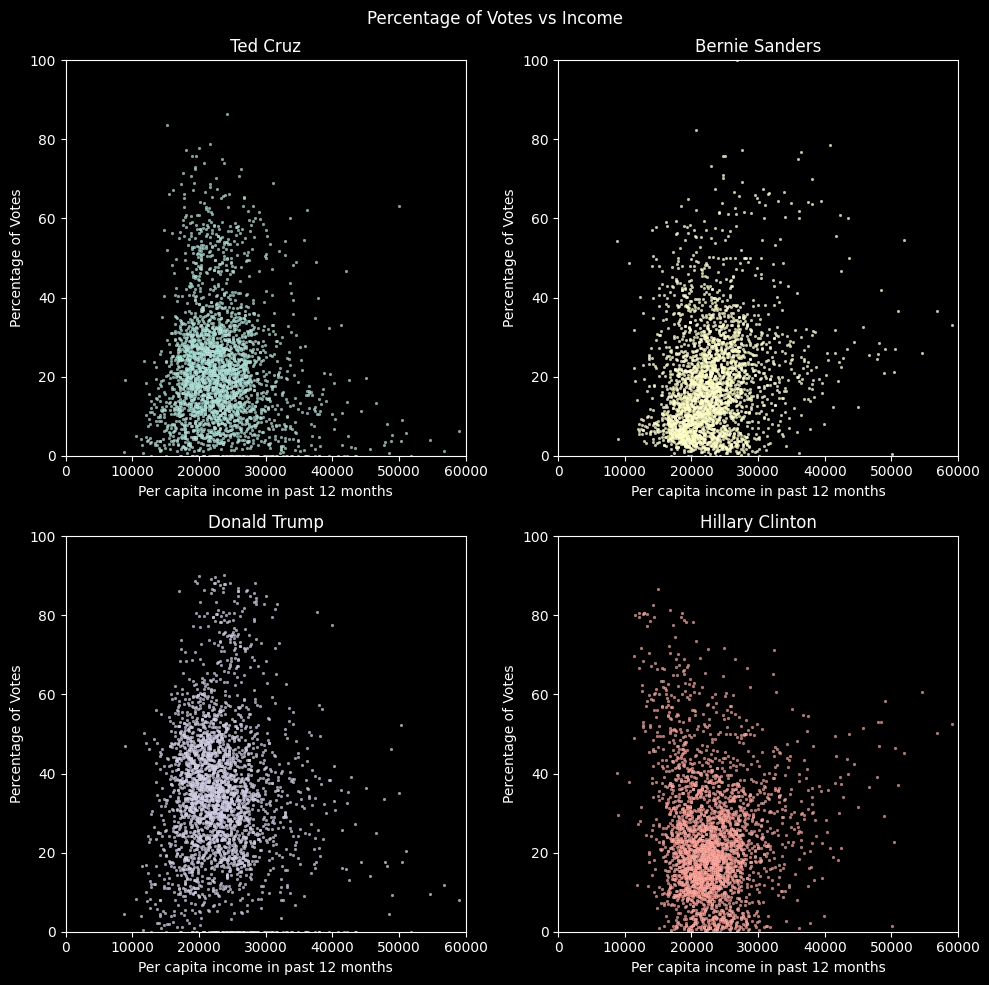

In [73]:
x = df["Per capita money income in past 12 months (2013 dollars), 2009-2013"]
candidate_cols = ["Ted Cruz", "Bernie Sanders", "Donald Trump", "Hillary Clinton"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, candidate in enumerate(candidate_cols):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    y = (
        df[candidate] / df[candidate_cols].sum(axis=1) * 100
    )  # Calculate percentage of votes
    sns.scatterplot(x=x, y=y, color=f"C{i}", alpha=0.8, ax=ax, s=4)

    ax.set_xlabel("Per capita income in past 12 months")
    ax.set_ylabel("Percentage of Votes")
    ax.set_title(candidate)
    ax.set_xlim(0, 60000)
    ax.set_ylim(0, 100)
plt.suptitle("Percentage of Votes vs Income")
plt.tight_layout()
plt.show()

Donald Trump get more precents in main population, range between 15000 and 30000. 

## Demography

In [26]:
df = cdf(rfdf)

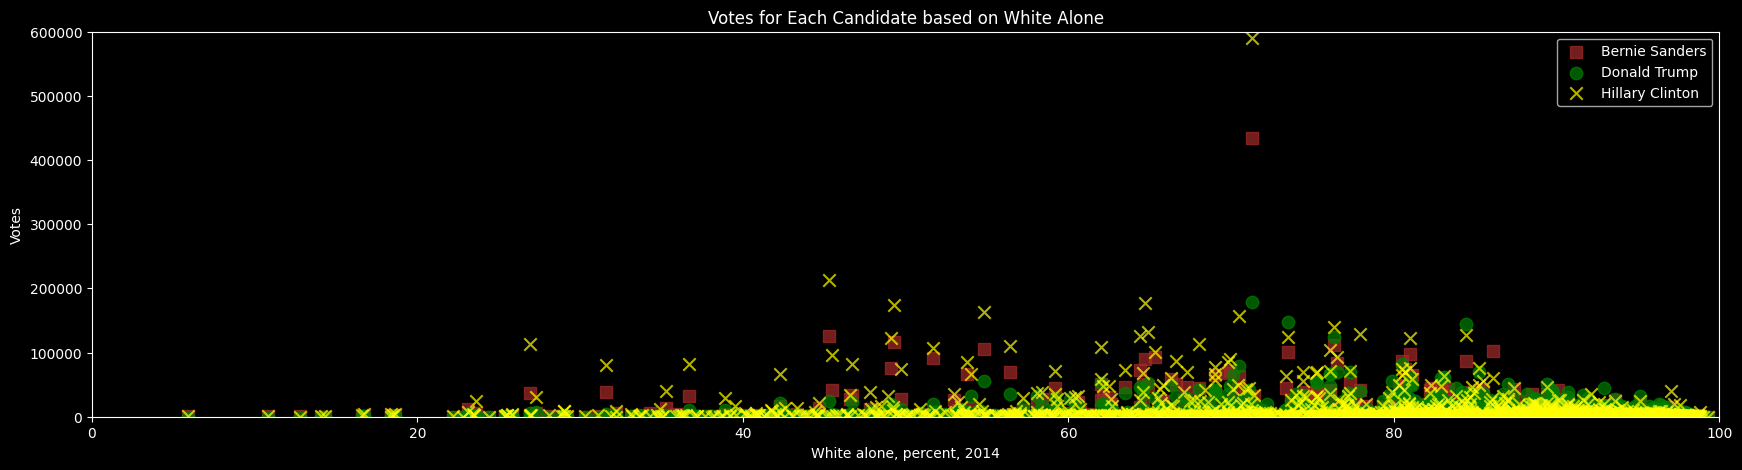

In [74]:
candidate_columns = ["Bernie Sanders", "Donald Trump", "Hillary Clinton"]
sorted_df = df.sort_values("White alone, percent, 2014", ascending=False)
vote_limit = 600000  # Set the limit for the highest votes to be displayed
colors = ["brown", "green", "yellow"]
markers = ["s", "o", "x"]
plt.figure(figsize=(21, 5))

for i, candidate in enumerate(candidate_columns):
    filtered_df = sorted_df[
        sorted_df[candidate] < vote_limit
    ]  # Filter out data points above the vote limit
    plt.scatter(
        filtered_df["White alone, percent, 2014"],
        filtered_df[candidate],
        color=colors[i],
        alpha=0.7,
        label=candidate,
        marker=markers[i],
        s=80,
    )

plt.xlabel("White alone, percent, 2014")
plt.ylabel("Votes")
plt.title("Votes for Each Candidate based on White Alone")
plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 600000)
plt.show()

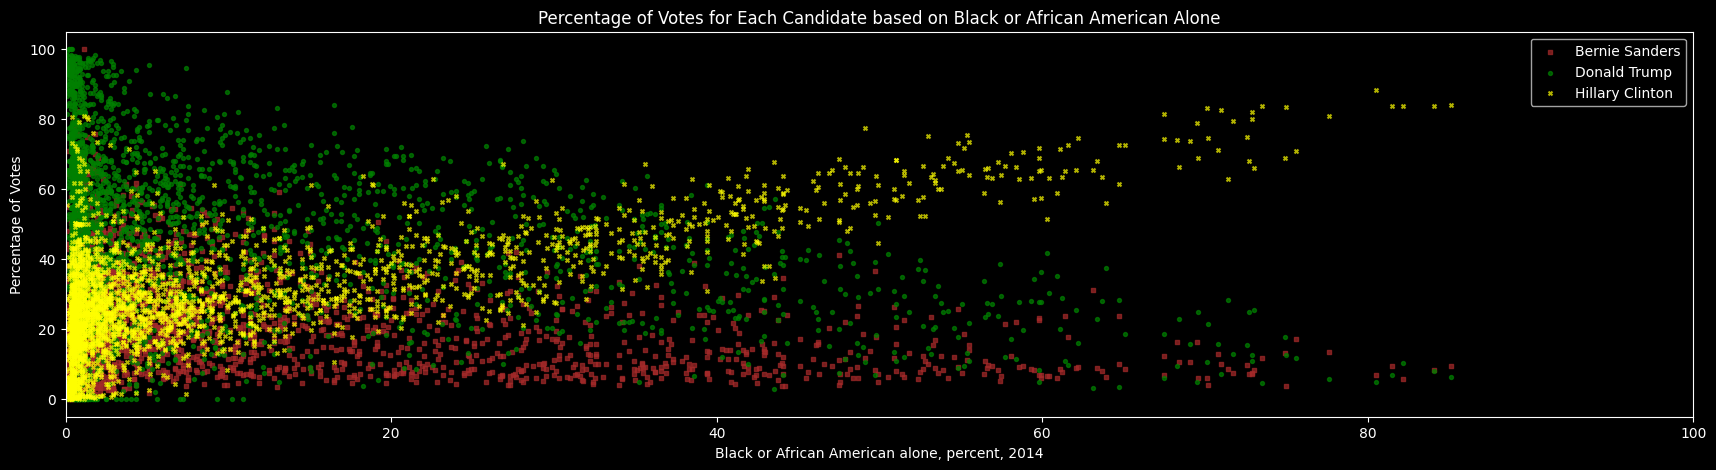

In [75]:
df["Total Votes"] = df[candidate_columns].sum(axis=1)

vote_limit = 600000

colors = ["brown", "green", "yellow", "purple", "orange", "gray"]
markers = ["s", "o", "x", "v", "D", "^"]

plt.figure(figsize=(21, 5))
for i, candidate in enumerate(candidate_columns):
    filtered_df = df[df[candidate] < vote_limit]
    percentage_votes = (filtered_df[candidate] / filtered_df["Total Votes"]) * 100

    plt.scatter(
        filtered_df["Black or African American alone, percent, 2014"],
        percentage_votes,
        color=colors[i % len(colors)],
        alpha=0.7,
        label=candidate,
        marker=markers[i % len(markers)],
        s=8,
    )

plt.xlabel("Black or African American alone, percent, 2014")
plt.ylabel("Percentage of Votes")
plt.title(
    "Percentage of Votes for Each Candidate based on Black or African American Alone"
)
plt.legend()
plt.xlim(0, 100)

plt.show()

black votes for Clinton


In [154]:
cf.iloc[0, 11:19]

White alone, percent, 2014                                         77.4
Black or African American alone, percent, 2014                     13.2
American Indian and Alaska Native alone, percent, 2014              1.2
Asian alone, percent, 2014                                          5.4
Native Hawaiian and Other Pacific Islander alone, percent, 2014     0.2
Two or More Races, percent, 2014                                    2.5
Hispanic or Latino, percent, 2014                                  17.4
White alone, not Hispanic or Latino, percent, 2014                 62.1
Name: 0, dtype: object

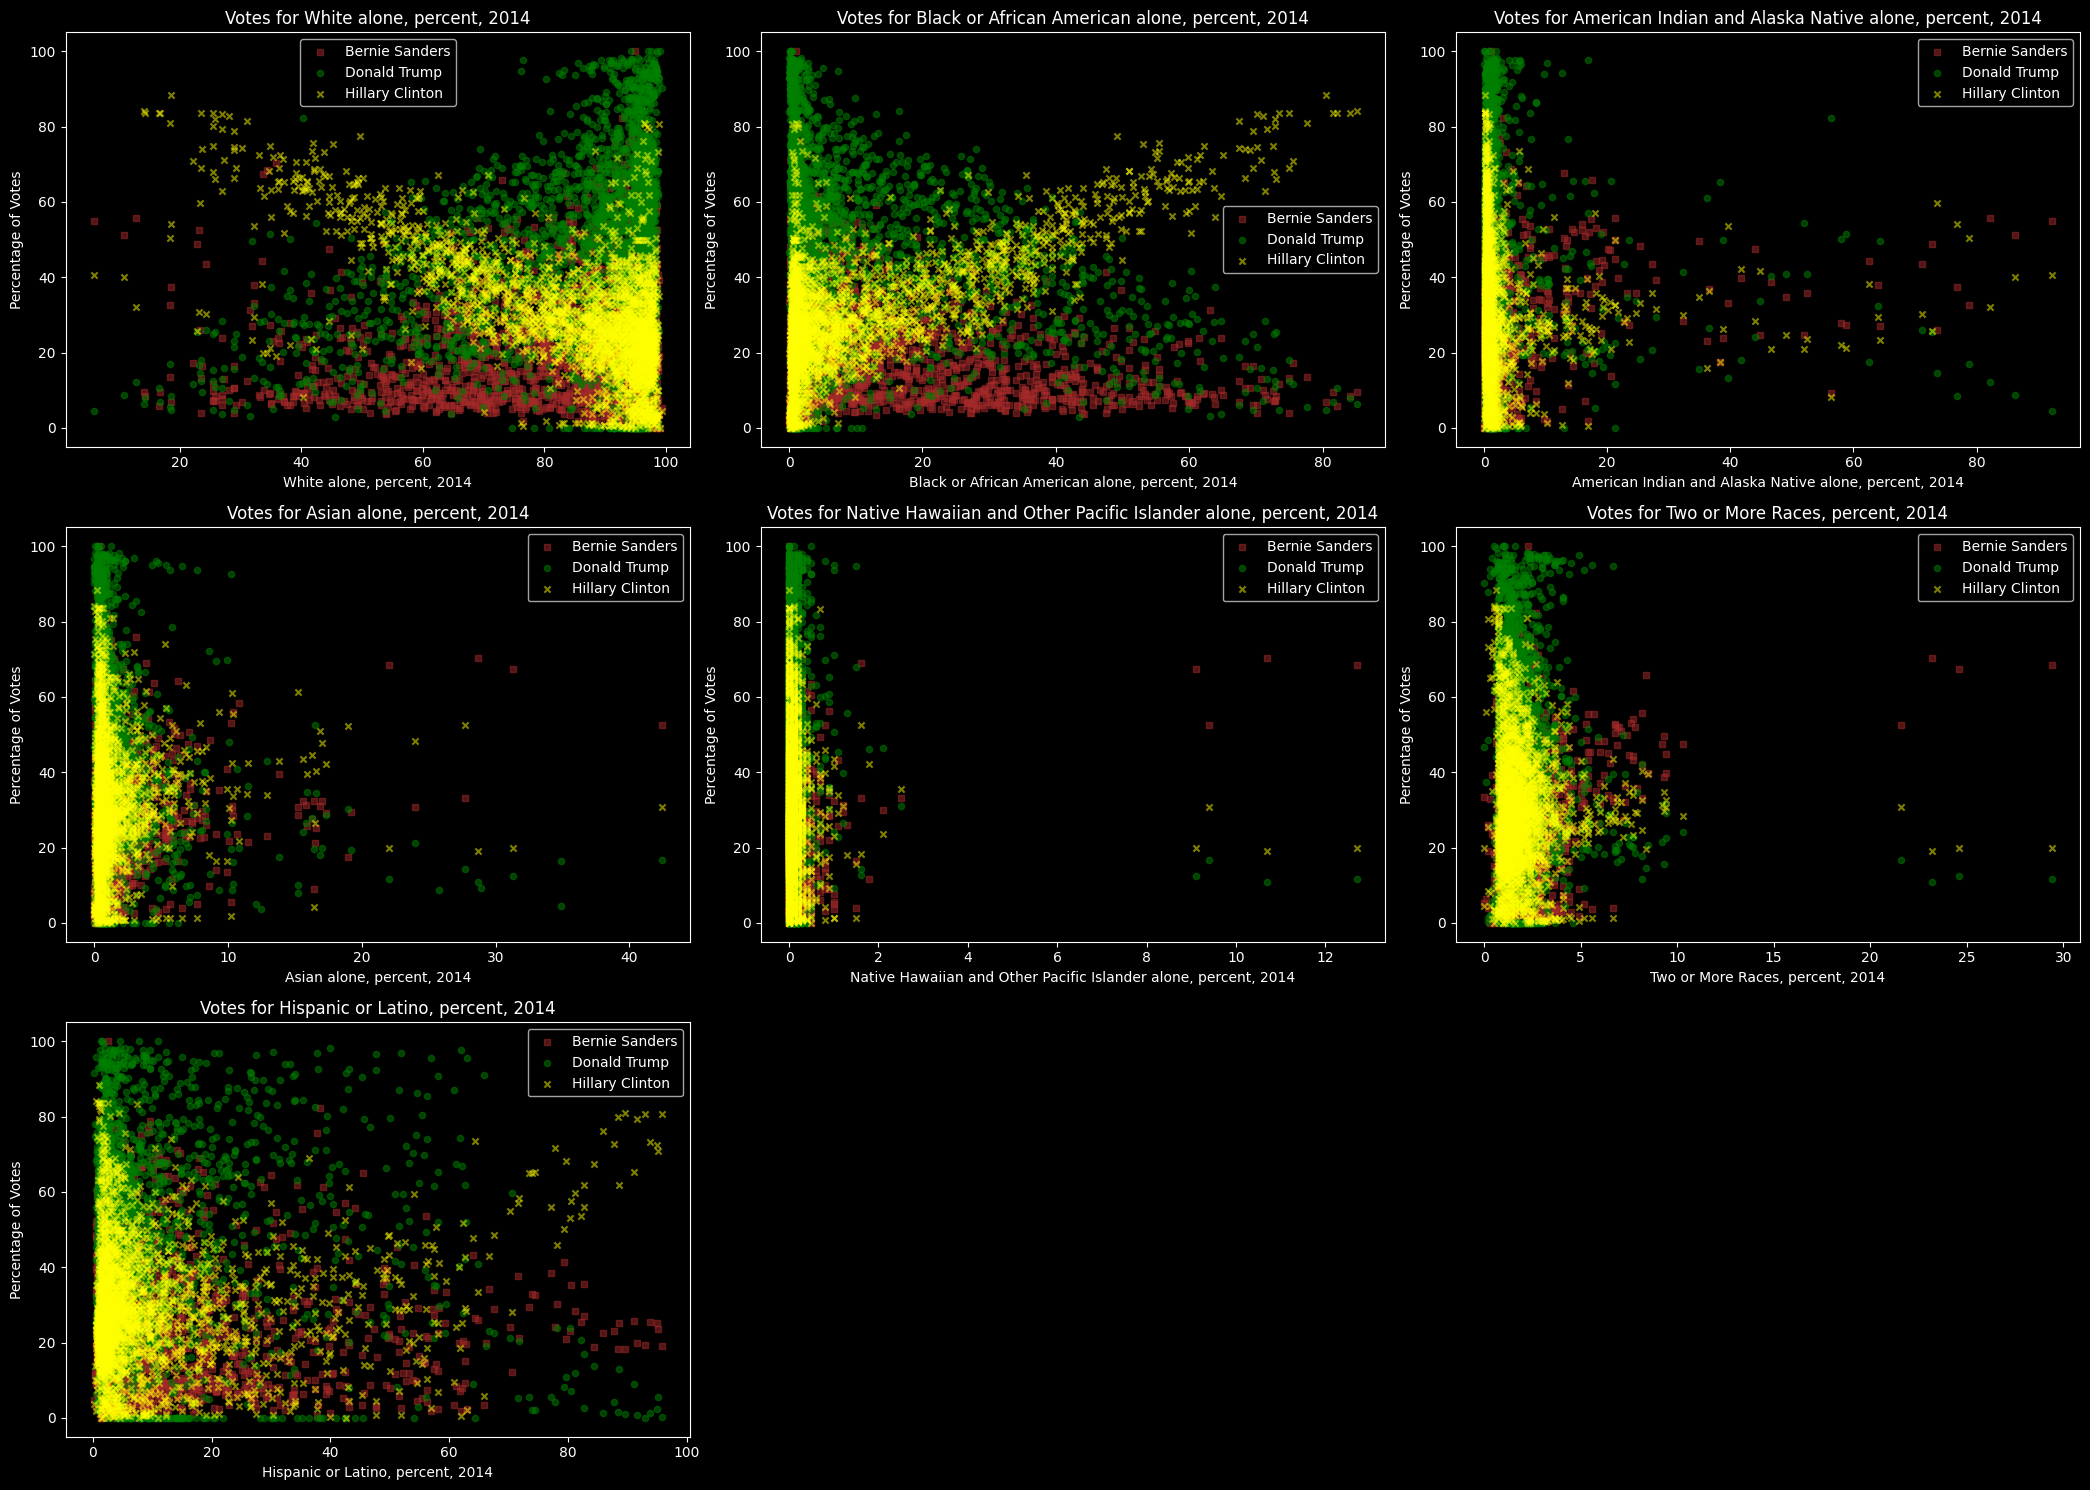

In [30]:
import matplotlib.pyplot as plt

candidate_columns = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
]
df["Total Votes"] = df[candidate_columns].sum(axis=1)

vote_limit = 60000


colors = ["brown", "green", "yellow"]
markers = ["s", "o", "x", "v", "D", "^"]

plt.figure(figsize=(21, 15))

for i, demographic in enumerate(
    [
        "White alone, percent, 2014",
        "Black or African American alone, percent, 2014",
        "American Indian and Alaska Native alone, percent, 2014",
        "Asian alone, percent, 2014",
        "Native Hawaiian and Other Pacific Islander alone, percent, 2014",
        "Two or More Races, percent, 2014",
        "Hispanic or Latino, percent, 2014",
    ]
):
    plt.subplot(3, 3, i + 1)

    # Iterate through candidate columns
    for j, candidate in enumerate(candidate_columns):
        filtered_df = df[df[candidate] < vote_limit]
        percentage_votes = (filtered_df[candidate] / filtered_df["Total Votes"]) * 100

        plt.scatter(
            filtered_df[demographic],
            percentage_votes,
            color=colors[j % len(colors)],
            alpha=0.5,
            label=candidate,
            marker=markers[j % len(markers)],
            s=20,
        )
    plt.xlabel(demographic)
    plt.ylabel("Percentage of Votes")
    plt.title(f"Votes for {demographic}")
    plt.legend()

plt.tight_layout()
plt.show()

we see that white population votes for Trump, Black and Latino for Clinton, all other possibly for Sanders.

# General Conclusion

Regional variations in demographics and voting behaviors played a role in Trump's victory. 
Appeal to working-class voters with promises to bring back jobs and protect industries.
Support from higher-income individuals due to his emphasis on tax cuts and pro-business policies.

# Future analysis

There is around 7 % of data missing. Minimise this by moving votes from city, district and merged counties to relevant counties.

Deploy map with two candidates, where scale is from two colors. Lets say yellow will be Clinton and Blue will be Sanders. Counties that have similar amount of votes from each candidate would be green, the ones leaning towards yellow Clinton and the ones leaning twards blue would be Sanders voters.

Deploy feature maps from county facts in similar way.